# 1. Introduction
>Just one more kernel with CNN in this competition :)
To work with large data, use ImageDataGenerator.flow_from_dataframe as input for model.
First, import necessary libraries:

In [1]:
#####################################
# Libraries
#####################################
# Common libs
import pandas as pd
import numpy as np
import sys
import os
import random
import time
from datetime import datetime
from pathlib import Path

# Image processing
import imageio
import PIL
import cv2
import skimage.transform
#from skimage.transform import rescale, resize, downscale_local_mean

# Charts
import matplotlib.pyplot as plt
import seaborn as sns

# ML, statistics
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report

# Tensorflow
#from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import MultiLabelBinarizer
 

#############################################
# Settings
#############################################

pd.set_option("display.max_columns", None)

plt.style.use('fivethirtyeight')
#plt.style.use('seaborn')

print(os.listdir("../input"))
# Any results you write to the current directory are saved as output.

INPUT_DIR = "../input/plant-pathology-2021-fgvc8/"
PRETRAINED_DIR = "../input/pretrained-model/"
#OUTPUT_DIR ="./"    
OUTPUT_DIR = "./model/"    ## need remove in kaggle and enble line above

TRAIN_DATA_DIR = INPUT_DIR + 'train_images'
#TRAIN_DATA_DIR = INPUT_DIR + 'img_sz_512'

#IMSIZES = (224, 240, 260, 300, 380, 456, 528, 600)

#NUM_CLASSES = 7 #12

NUM_CLASSES = 6 #12
IMAGE_SIZE= (224,224) #(300,300) # 

BATCH_SIZE = 32 #32   ## need change to 16 in kaggle
TRAIN_BATCH_SIZE = 1024 #512

print(os.listdir(OUTPUT_DIR))
print(os.listdir(INPUT_DIR))

['plant-pathology-2021-fgvc8', 'pretrained-model', 'results v21.zip', 'results-v2.zip', 'submission.csv', '__results___files']
['best_DenseNet121.h5', 'best_EfficientNetB7.h5', 'best_XceptionDenseNet121-v1.h5', 'best_XceptionDenseNet121.h5', 'best_XceptionDenseNet121_1.h5', 'best_XceptionDenseNet121_2.h5', 'best_XceptionDenseNet121_3.h5', 'plant_model.hdf5']
['img_sz_256', 'img_sz_384', 'img_sz_512', 'img_sz_640', 'sample_submission.csv', 'submission-v2.csv', 'test_images', 'test_images1', 'train.csv', 'train_images']


In [2]:
toy=False

all_df = pd.read_csv(INPUT_DIR + "train.csv")
if toy:
    all_df = all_df.sample(5000)

all_df = all_df.loc[all_df['labels'] != 'cider_apple_rust']  ## need remove in kaggle

print(all_df.shape)
all_df.head()

(16772, 2)


,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [3]:
NB_TRAIN = all_df.shape[0]  #15930 #4275 #32706
NB_VALID = NB_TRAIN * 0.1 #1770 #475 #10902

# 2. Exploratory Data Analysis
>Check labels balancing
Check whether labels are balanced

In [4]:
# Checking if there are any null values in the dataset
all_df.isnull().any()

image     False
labels    False
dtype: bool

In [5]:
# Checking the column data type
all_df.dtypes

image     object
labels    object
dtype: object

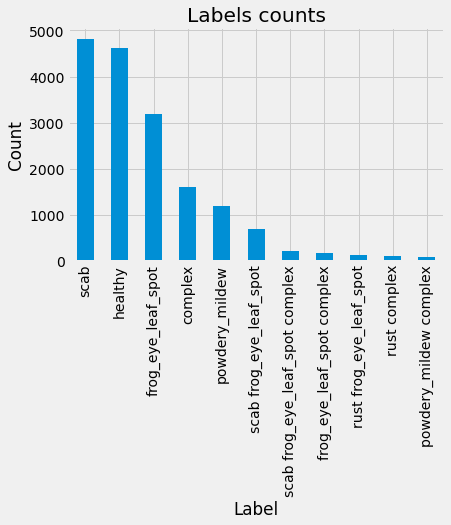

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64


In [6]:
all_df.labels.value_counts().plot(kind='bar')
plt.title('Labels counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()
print(all_df.labels.value_counts())

In [7]:
train = pd.DataFrame()
train['image'] = all_df['image']
train['labels'] = all_df['labels'].apply(lambda string: string.split(' '))
train.head()

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]


Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')
complex               2151
frog_eye_leaf_spot    4352
healthy               4624
powdery_mildew        1271
rust                   217
scab                  5712
dtype: int64
['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']


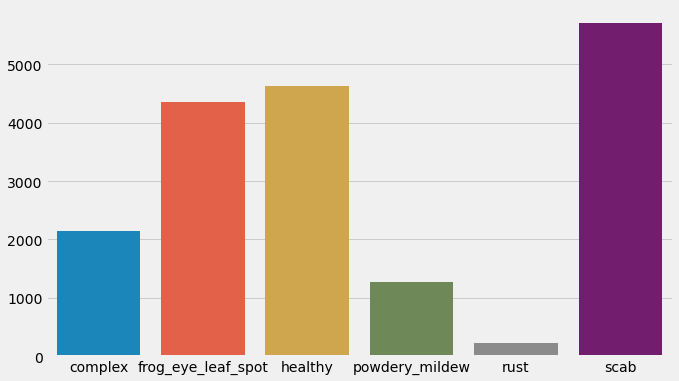

In [8]:
s = list(train['labels'])
mlb = MultiLabelBinarizer()
trainx = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=train.index)
print(trainx.columns)
print(trainx.sum())

labels = list(trainx.sum().keys())
print(labels)
label_counts = trainx.sum().values.tolist()

fig, ax = plt.subplots(1,1, figsize=(10,6))

sns.barplot(x= labels, y= label_counts, ax=ax)



## View sample images

# 3. Data preparation

## Create image generator
>Keras ImageDataGenerator can work with dataframe of file names. Our train, validation and test dataframes contain file name in id column and ImageDataGenerator can understand id.

In [9]:
class Generators:
    """
    Train, validation and test generators
    """
    def __init__(self, train_df, test_df):
        self.batch_size= BATCH_SIZE #16 #1024 #32 #8
        self.img_size= IMAGE_SIZE #(256,256)#(512,512)#(192,128) #(96,64) (384,256)  #(4000,2672)

        # Base train/validation generator
        _datagen = ImageDataGenerator(
            rescale=1./255.,
            #validation_split=0.1,
            brightness_range=(0.8, 1.2),
            #featurewise_center=False,
            #featurewise_std_normalization=False,
            fill_mode='nearest',
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10, #180,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.15, # Randomly zoom image 
            width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True  # randomly flip images
            )
 
        # Train generator
        self.train_generator = _datagen.flow_from_dataframe(
            dataframe=train_df, #all_df, #
            directory=TRAIN_DATA_DIR,
            x_col="image",
            y_col="labels",
            #has_ext=False,
            
            #subset="training",
            batch_size=self.batch_size,
            seed=42,
            shuffle=False, #True,
            class_mode="categorical",
            target_size=self.img_size)
        print('Train generator created')
        # Validation generator
        self.val_generator = _datagen.flow_from_dataframe(
            dataframe=test_df,#test_df ,#
            directory=TRAIN_DATA_DIR,
            x_col="image",
            y_col="labels",
            #has_ext=False,
            
            #subset="validation",
            batch_size=self.batch_size,
            seed=42,
            shuffle=False, #True,
            class_mode="categorical",
            target_size=self.img_size)    
        print('Validation generator created')


In [10]:
train_df, test_df = train_test_split(train, random_state=24, test_size=0.05, shuffle=False)        
# Create generators   
generators = Generators(train_df, test_df)
print("Generators created")
print(train_df.shape,test_df.shape)

Found 15933 validated image filenames belonging to 6 classes.
Train generator created
Found 839 validated image filenames belonging to 6 classes.
Validation generator created
Generators created
(15933, 2) (839, 2)


{'complex': 0, 'frog_eye_leaf_spot': 1, 'healthy': 2, 'powdery_mildew': 3, 'rust': 4, 'scab': 5}
{0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']


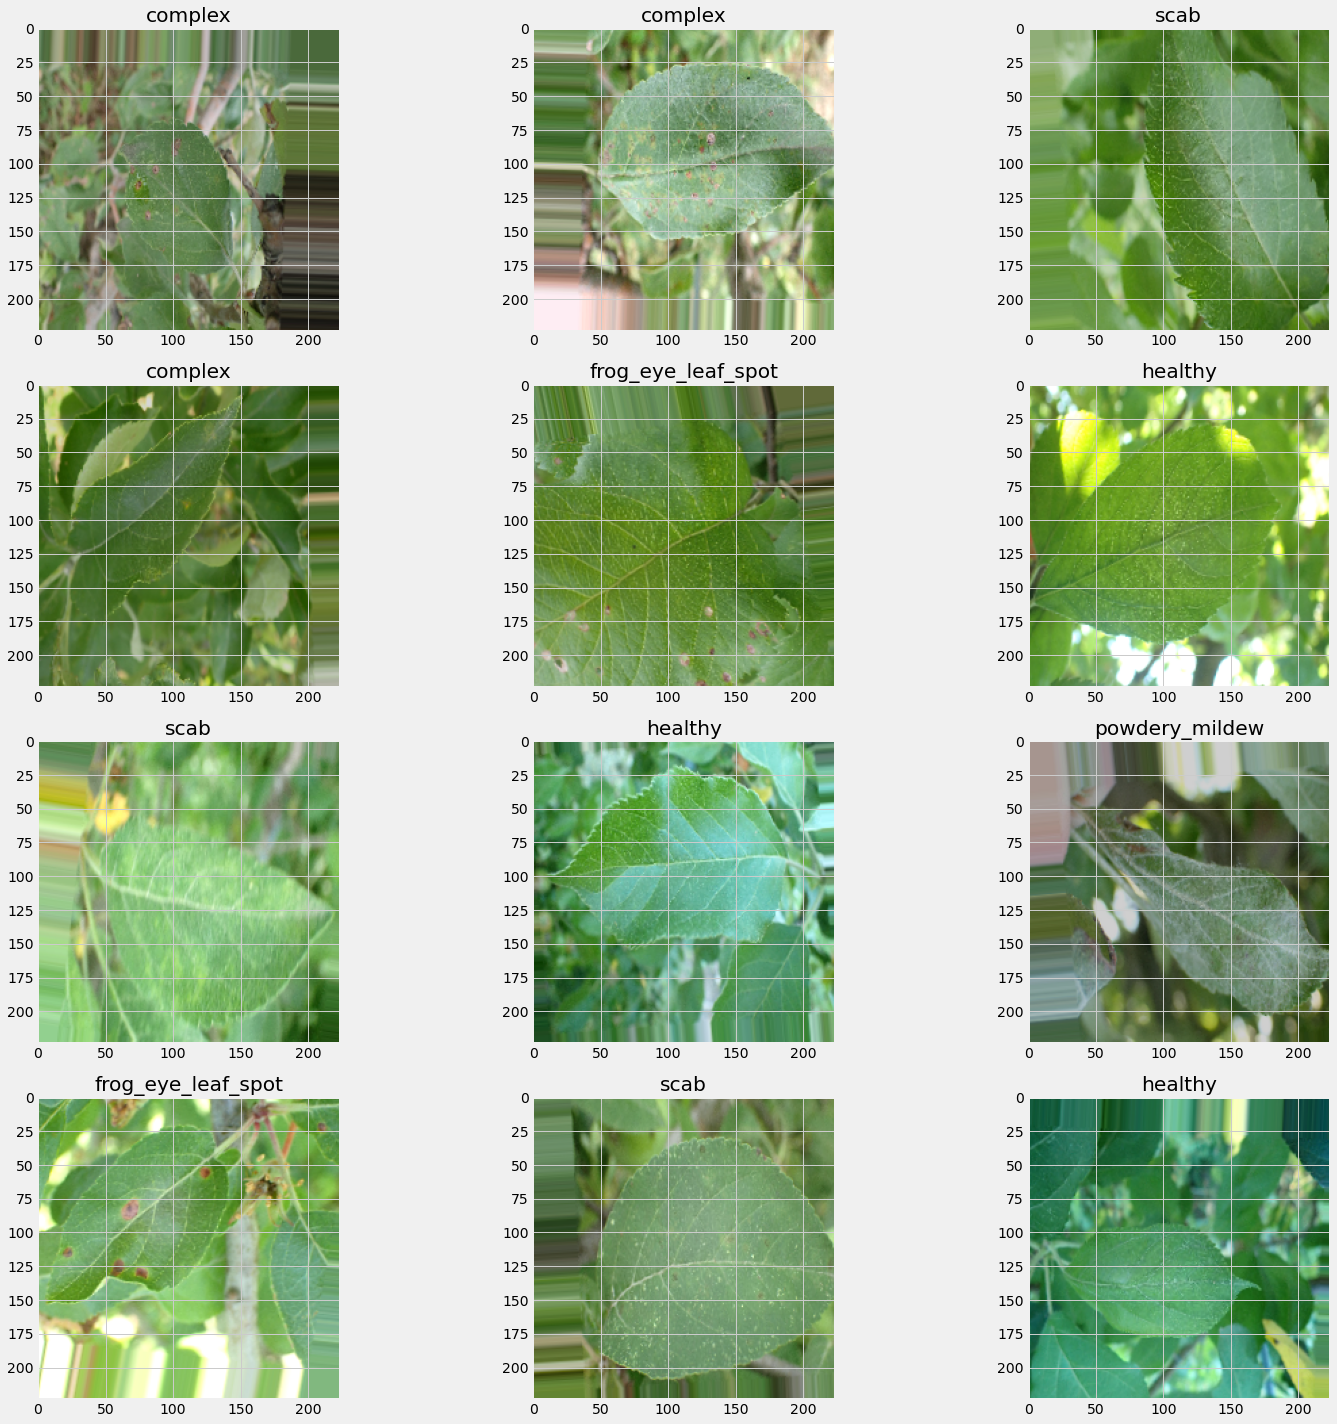

In [11]:
#print(generators.train_generator.classes)
print(generators.train_generator.class_indices)
class_labels = generators.train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
print(class_labels)
classes = list(class_labels.values())
print(classes)        

def get_class(one_hot):
    for i in range(NUM_CLASSES):
        if one_hot[i] == 1:
            return classes[i]
    
fig=plt.figure(figsize=(26, 20))
columns = 3
rows = 4
for i in range(1, columns*rows +1):
    img_batch, label_batch = generators.train_generator.next()
    fig.add_subplot(rows, columns, i)
    
    plt.title(get_class(label_batch[i]))  
    plt.imshow(img_batch[i])
    #plt.axis('off')
    fig.tight_layout()
    
plt.show()

# 4. Create and train the model
>Put all creation and training code in one class. Will experiment with model architecture later.

Learning rate schedule: 1e-05 to 0.0001 to 1e-05


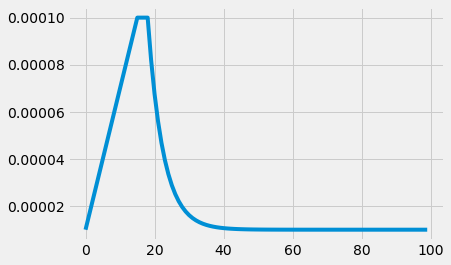

In [12]:
LR_START = 0.00001
LR_MAX = 0.0001 
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 15
LR_SUSTAIN_EPOCHS = 3
LR_EXP_DECAY = .8
EPOCHS = 100

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [13]:
class ModelTrainer:
    """
    Create and fit the model
    """
    
    def __init__(self, generators):
        self.nb_train_samples = NB_TRAIN  #15930 #4275 #32706
        self.nb_validation_samples = NB_VALID #1770 #475 #10902
        self.batch_size =  TRAIN_BATCH_SIZE #512 #512 #32 #1024   #32
               
        
        self.generators = generators
        self.img_width = IMAGE_SIZE[0]
        self.img_height = IMAGE_SIZE[1]
        print(self.img_width,self.img_height)
        
    
    def create_model(self, model_name):
        if model_name == "Xception" :
                model = self.create_model_1()
        elif model_name == "EfficientNetB7": 
                model = self.create_model_0()                
        elif model_name == "DenseNet121": 
                model = self.create_model_2()
        elif model_name == "XceptionDenseNet121": 
                model = self.create_model_3()
        elif model_name == "InceptionResNetV2": 
                model = self.create_model_4()
        elif model_name == "ResNet50V2": 
                model = self.create_model_5()
        elif model_name == "VGG16": 
                model = self.create_model_6()
        elif model_name == "middle": 
                model = self.create_model_middle()
        elif model_name == "small": 
                model = self.create_model_small()
        else:
                print("Model not found")
        self.model_name = model_name
        return model
    

    def create_model_0(self):
        path0 = PRETRAINED_DIR + 'efficientnetb7_notop.h5'
        pretrained_model = tf.keras.applications.EfficientNetB7(include_top=False, weights=path0, #drop_connect_rate=0.4,
                                                                 input_shape=(self.img_width, self.img_height, 3))
        model = tf.keras.models.Sequential([
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(NUM_CLASSES,activation='sigmoid')
        ])
        
        # Freezing the weights
        for layer in model.layers[:-1]:
            layer.trainable=False
    
        return model    
    
    #Total params: 20,886,068
    def create_model_1(self):
        path1 = PRETRAINED_DIR + 'xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
        pretrained_model = tf.keras.applications.xception.Xception(include_top=False, weights=path1, input_shape=(self.img_width, self.img_height, 3))
        model = tf.keras.models.Sequential([
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
        ])
        return model
    
    def create_model_2(self):
        path2 = PRETRAINED_DIR + 'densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'
        pretrained_model = tf.keras.applications.densenet.DenseNet121(include_top=False, weights=path2,input_shape=(self.img_width, self.img_height, 3))
        model = tf.keras.models.Sequential([
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
        ])
    
        return model

    def create_model_3(self):
        path1 = PRETRAINED_DIR + 'xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
        xception_model = tf.keras.models.Sequential([
           tf.keras.applications.xception.Xception(include_top=False, weights=path1, input_shape=(self.img_width, self.img_height, 3)),#(512, 512, 3)),
           tf.keras.layers.GlobalAveragePooling2D(),
           #tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
           tf.keras.layers.Dense(NUM_CLASSES,activation='sigmoid')
        ])
        # Freezing the weights
        #for layer in xception_model.layers[:-1]:
        #    layer.trainable=False
            
        #xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        #xception_model.summary()
        path2 = PRETRAINED_DIR + 'densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'
        densenet_model = tf.keras.models.Sequential([
            tf.keras.applications.densenet.DenseNet121(include_top=False, weights=path2,input_shape=(self.img_width, self.img_height, 3)),#(512, 512, 3)),
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
            tf.keras.layers.Dense(NUM_CLASSES,activation='sigmoid')
        ])
        #for layer in densenet_model.layers[:-1]:
        #    layer.trainable=False
        #densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        #densenet_model.summary()
        
        inputs = tf.keras.Input(shape=(self.img_width, self.img_height, 3)) #(512, 512, 3))

        xception_output = xception_model(inputs)
        densenet_output = densenet_model(inputs)

        outputs = tf.keras.layers.average([densenet_output, xception_output])


        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model
 
    def create_model_4(self):
        pretrained_model = tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(self.img_width, self.img_height, 3))
        model = tf.keras.models.Sequential([
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
        ])
        return model
    
    def create_model_5(self):
        pretrained_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(self.img_width, self.img_height, 3))
        model = tf.keras.models.Sequential([
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
        ])
    
        return model

    #Total params: 14,720,844
    def create_model_6(self):
        pretrained_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(self.img_width, self.img_height, 3))
        model = tf.keras.models.Sequential([
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
        ])
        return model    
    
    def create_model_middle(self):
        model = Sequential()

        # Padding = 'same'  results in padding the input such that
        # the output has the same length as the original input
        model.add(Conv2D(32, (3, 3), padding='same',
                         input_shape= (self.img_width, self.img_height, 3)))
        model.add(Activation('relu'))
        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(12))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(NUM_CLASSES))
        model.add(Activation('softmax'))

        return model
    
    def create_model_vgg16(self):
        input_shape = (224, 224, 3)

        model = Sequential([
            Conv2D(64, (3, 3), input_shape=input_shape, padding='same',
                   activation='relu'),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            Conv2D(128, (3, 3), activation='relu', padding='same',),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(256, (3, 3), activation='relu', padding='same',),
            Conv2D(256, (3, 3), activation='relu', padding='same',),
            Conv2D(256, (3, 3), activation='relu', padding='same',),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(512, (3, 3), activation='relu', padding='same',),
            Conv2D(512, (3, 3), activation='relu', padding='same',),
            Conv2D(512, (3, 3), activation='relu', padding='same',),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(512, (3, 3), activation='relu', padding='same',),
            Conv2D(512, (3, 3), activation='relu', padding='same',),
            Conv2D(512, (3, 3), activation='relu', padding='same',),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Flatten(),
            Dense(4096, activation='relu'),
            Dense(4096, activation='relu'),
            Dense(1000, activation='softmax')
        ])
        return model
    
            
    #Total params: 33,560,364    
    def create_model_small(self):
        """
        Build CNN model using img_width, img_height from fields.
        """
        model=Sequential()
        model.add(Conv2D(16, kernel_size=3, input_shape=(self.img_width, self.img_height,3), activation='relu', padding='same'))
        model.add(MaxPooling2D(2))
        model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
        model.add(Dropout(0.1))
        model.add(Flatten())
        model.add(Dense(64, activation = "relu"))        
        # 1 y label
        model.add(Dense(NUM_CLASSES, activation='softmax'))
        #model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

        # We use a very small learning rate 
        model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])
        return model
    
    def train(self, model, toy, model_name):
        """
        Train the model
        """
        if toy:
            epochs=10
            steps_per_epoch=10
            validation_steps=1
        else:
            epochs=50
            steps_per_epoch = self.nb_train_samples / self.batch_size
            validation_steps= self.nb_validation_samples / self.batch_size


        # val_accuracy should be try and compare with val_loss
        # We'll stop training if no improvement after some epochs
        earlystopper = EarlyStopping(monitor='val_loss', 
                            min_delta = 0, 
                            patience = 10,
                            verbose = 1,
                            restore_best_weights = True)

        #reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
        #                           verbose=1, mode='max', min_lr=0.00001)
        reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', #'loss',
                              factor = 0.5,
                              patience = 2,
                              verbose = 1,
                              min_lr=0.000001,
                              min_delta = 0.0001)
        # Save the best model during the traning
        # loss,accuracy,val_loss,val_accuracy,lr
        check_name = OUTPUT_DIR +  model_name #'best_'+self.model_name+'.h5'
        print(check_name)
        checkpointer = ModelCheckpoint( check_name
                                        #,monitor='val_loss'
                                        #,mode="min"
                                        #,monitor='val_accuracy'
                                        ,monitor='val_f1_score'
                                        ,mode="max"                                       
                                        ,verbose=1
                                        ,save_best_only=True)
                                        #,save_weights_only=True)

        #callbacks = [ checkpointer,lr_callback]        
            
        callbacks = [earlystopper, checkpointer, reduce_lr] #lr_callback] #
        # Train
        training = model.fit(self.generators.train_generator
                                ,epochs=epochs
                                ,steps_per_epoch=steps_per_epoch
                                ,validation_data=self.generators.val_generator
                                ,validation_steps=validation_steps
                                ,callbacks=callbacks
                                ,use_multiprocessing=False
                                ,shuffle=True
                                ,verbose=True)     
        
        # Get the best saved weights
        #model.load_weights(check_name)
        return training


In [14]:
# Create and train the model
#trainer = ModelTrainer(generators)
#f1 = tfa.metrics.F1Score(num_classes=6, average='macro')
#model = trainer.create_model("XceptionDenseNet121")
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1])
#model.summary()
#model.load_weights(PRETRAINED_DIR + 'best_XceptionDenseNet121_v2.h5')

In [15]:
#!pip install iterative-stratification

In [16]:

#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit

from sklearn.model_selection import StratifiedKFold, KFold

def get_model_name(k):
    return 'model_'+str(k)+'.h5'

#mlb = MultiLabelBinarizer()
#Y = mlb.fit_transform(train_df.labels.values)


Y = train_df[['labels']]
n = len(Y)
nfold = 5

kf = KFold(n_splits = 5)                         
#skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 
#mskf = MultilabelStratifiedKFold(n_splits=nfold, shuffle=True, random_state=7)

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
VALIDATION_F1 = []

#save_dir = './model/'
fold_var = 1



In [ ]:
#for train_index, val_index in mskf.split(Y,Y):
for train_index, val_index in kf.split(np.zeros(n),Y):    
    training_data = train_df.iloc[train_index]
    validation_data = train_df.iloc[val_index]
    
    generators1 = Generators(training_data, validation_data)
    
    #train_data_generator = generators.train_generator
    valid_data_generator  = generators1.val_generator
    
    # Create and train the model
    trainer = ModelTrainer(generators1)
    f1 = tfa.metrics.F1Score(num_classes=6, average='macro')
    model = trainer.create_model("XceptionDenseNet121")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1])
    #model.load_weights(PRETRAINED_DIR + 'best_XceptionDenseNet121_v2.h5')
    
    model_name = "best_XceptionDenseNet121_"+str(fold_var)+".h5"
    start = time.time()
    training=trainer.train(model, toy, model_name)
    print("Trained Time : ", time.time() - start)
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    
    
    
    model.load_weights(OUTPUT_DIR + model_name)
    results = model.evaluate(valid_data_generator)
    results = dict(zip(model.metrics_names,results))
    
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    VALIDATION_F1.append(results['f1_score'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1

Found 12746 validated image filenames belonging to 6 classes.
Train generator created
Found 3187 validated image filenames belonging to 6 classes.
Validation generator created
224 224
./model/best_XceptionDenseNet121_1.h5
Epoch 1/50
16/16 [==============================] - 998s 59s/step - loss: 0.4301 - accuracy: 0.5408 - f1_score: 0.3899 - val_loss: 1.0058 - val_accuracy: 0.1719 - val_f1_score: 0.0598

Epoch 00001: val_f1_score improved from -inf to 0.05983, saving model to ./model\best_XceptionDenseNet121_1.h5
Epoch 2/50
16/16 [==============================] - 1008s 61s/step - loss: 0.2404 - accuracy: 0.7638 - f1_score: 0.5418 - val_loss: 0.9386 - val_accuracy: 0.3594 - val_f1_score: 0.3313

Epoch 00002: val_f1_score improved from 0.05983 to 0.33131, saving model to ./model\best_XceptionDenseNet121_1.h5
Epoch 3/50
16/16 [==============================] - 1033s 63s/step - loss: 0.2234 - accuracy: 0.7588 - f1_score: 0.5858 - val_loss: 0.8159 - val_accuracy: 0.3750 - val_f1_score: 0.25


Epoch 00029: val_f1_score did not improve from 0.75196
Epoch 30/50
16/16 [==============================] - 620s 38s/step - loss: 0.1363 - accuracy: 0.8685 - f1_score: 0.6927 - val_loss: 0.0938 - val_accuracy: 0.9219 - val_f1_score: 0.7530

Epoch 00030: val_f1_score improved from 0.75196 to 0.75297, saving model to ./model\best_XceptionDenseNet121_1.h5
Epoch 31/50
16/16 [==============================] - 617s 38s/step - loss: 0.1087 - accuracy: 0.8738 - f1_score: 0.7038 - val_loss: 0.1370 - val_accuracy: 0.9219 - val_f1_score: 0.7475

Epoch 00031: val_f1_score did not improve from 0.75297
Epoch 32/50
16/16 [==============================] - 624s 38s/step - loss: 0.1463 - accuracy: 0.8555 - f1_score: 0.6885 - val_loss: 0.1313 - val_accuracy: 0.9219 - val_f1_score: 0.7520

Epoch 00032: val_f1_score did not improve from 0.75297

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 33/50
16/16 [==============================] - 620s 38s/step - loss: 0.118

16/16 [==============================] - 604s 37s/step - loss: 0.1231 - accuracy: 0.8705 - f1_score: 0.7067 - val_loss: 0.1214 - val_accuracy: 0.8281 - val_f1_score: 0.6837

Epoch 00017: val_f1_score did not improve from 0.70882
Epoch 18/50
16/16 [==============================] - 609s 37s/step - loss: 0.1590 - accuracy: 0.8161 - f1_score: 0.6427 - val_loss: 0.1121 - val_accuracy: 0.9062 - val_f1_score: 0.7473

Epoch 00018: val_f1_score improved from 0.70882 to 0.74727, saving model to ./model\best_XceptionDenseNet121_2.h5

Epoch 00018: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 19/50
16/16 [==============================] - 614s 37s/step - loss: 0.1080 - accuracy: 0.9050 - f1_score: 0.7303 - val_loss: 0.0881 - val_accuracy: 0.8906 - val_f1_score: 0.7113

Epoch 00019: val_f1_score did not improve from 0.74727
Epoch 20/50
16/16 [==============================] - 595s 36s/step - loss: 0.1087 - accuracy: 0.9060 - f1_score: 0.7179 - val_loss: 0.0885 - val_accur

16/16 [==============================] - 915s 56s/step - loss: 0.1398 - accuracy: 0.8499 - f1_score: 0.7024 - val_loss: 0.2251 - val_accuracy: 0.7031 - val_f1_score: 0.5460

Epoch 00013: val_f1_score did not improve from 0.61232
Epoch 14/50
16/16 [==============================] - 915s 56s/step - loss: 0.1583 - accuracy: 0.8281 - f1_score: 0.6699 - val_loss: 0.2562 - val_accuracy: 0.6562 - val_f1_score: 0.5127

Epoch 00014: val_f1_score did not improve from 0.61232

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 15/50
16/16 [==============================] - 921s 56s/step - loss: 0.1634 - accuracy: 0.8228 - f1_score: 0.6623 - val_loss: 0.1950 - val_accuracy: 0.7344 - val_f1_score: 0.6044

Epoch 00015: val_f1_score did not improve from 0.61232
Epoch 16/50
16/16 [==============================] - 931s 57s/step - loss: 0.1296 - accuracy: 0.8538 - f1_score: 0.6876 - val_loss: 0.1778 - val_accuracy: 0.7500 - val_f1_score: 0.5797

Epoch 00016: val_f1_sc

16/16 [==============================] - 637s 39s/step - loss: 0.1126 - accuracy: 0.8712 - f1_score: 0.6957 - val_loss: 0.1217 - val_accuracy: 0.8750 - val_f1_score: 0.7038

Epoch 00043: val_f1_score did not improve from 0.71458
Epoch 44/50
16/16 [==============================] - 628s 38s/step - loss: 0.0964 - accuracy: 0.9088 - f1_score: 0.7238 - val_loss: 0.1204 - val_accuracy: 0.8438 - val_f1_score: 0.6833

Epoch 00044: val_f1_score did not improve from 0.71458
Epoch 45/50
16/16 [==============================] - 659s 40s/step - loss: 0.0929 - accuracy: 0.9227 - f1_score: 0.7049 - val_loss: 0.1250 - val_accuracy: 0.8438 - val_f1_score: 0.6764

Epoch 00045: val_f1_score did not improve from 0.71458
Epoch 46/50
16/16 [==============================] - 655s 40s/step - loss: 0.1082 - accuracy: 0.8719 - f1_score: 0.6980 - val_loss: 0.1329 - val_accuracy: 0.8281 - val_f1_score: 0.6828

Epoch 00046: val_f1_score did not improve from 0.71458
Epoch 47/50
16/16 [=============================

In [ ]:
#start = time.time()
#training=trainer.train(model, toy)
#print("Trained Time : ", time.time() - start)

#now = datetime.now()
#current_time = now.strftime("%H:%M:%S")
#print("Current Time =", current_time)

# 5. Evaluate trained model
Also put all evaluation code into one class for better code modularity.

In [ ]:

def get_one_hot(y_pred):
    result = np.zeros(shape=(len(y_pred), NUM_CLASSES))
    indices = []
    for i in range(len(y_pred)):
        pred = y_pred[i]
        temp = []
        for category in pred:   
            if category>=0.3:
                index1 = pred.index(category)
                temp.append(index1)
                result[i,index1] = 1
        if temp!=[]:
            indices.append(temp)
        else:
            index2 = np.argmax(pred)
            temp.append(index2)
            indices.append(temp)   
            result[i,index2] = 1
    return result.astype(int)

def get_pred_label(y_pred):
    indices = []
    for pred in y_pred:
        temp = []
        for category in pred:
            #print(category)
            if category>=0.3:
                temp.append(pred.index(category))
        #print(temp)
        if temp!=[]:
            indices.append(temp)
        else:
            temp.append(np.argmax(pred))
            indices.append(temp)
    y_pred_str = []        
    for image in indices:
        temp = []
        for i in image:
            #if i > 5:
            #    temp.append(classes[0])
            #else:
            temp.append(classes[i])

        y_pred_str.append(' '.join(temp))

    #print(y_pred_str)
    return y_pred_str

In [ ]:
class Evaluator:
    """
    Evaluaion :predict on test data (not submission data from test folder)
    and print reports, plot results etc.
    """
     
    def __init__(self, model, training, generator, y_true):
        mlb = MultiLabelBinarizer()
        
        self.training = training
        self.generator = generator
        # predict the data
        preds = model.predict(self.generator)
        self.y_pred = get_one_hot(preds.tolist())
        
        self.y_true = mlb.fit_transform(y_true)#.tolist()

        print(self.y_true.shape, self.y_pred.shape )


    def plot_history(self): 
        fig, ax1 = plt.subplots(figsize=(15, 8))
        history = self.training

        ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
        ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
        ax1.grid(True)
        ax1.set_xlabel('iteration')
        ax1.legend(loc="best", fontsize=9)    
        ax1.set_ylabel('loss', color='r')
        ax1.tick_params('y', colors='r')

        accname = "accuracy"
        if accname in history.history:
            ax2 = ax1.twinx()

            ax2.plot(history.history[accname], 'b', label="training acc ({:.4f})".format(history.history[accname][-1]))
            ax2.plot(history.history['val_' + accname], 'b--', label="validation acc ({:.4f})".format(history.history['val_' + accname][-1]))

            ax2.legend(loc="best", fontsize=12)
            ax2.set_ylabel('acc', color='b')        
            ax2.tick_params('y', colors='b')
    
    def plot_roc(self):
        print(self.y_true.shape, self.y_pred.shape)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        thresholds = dict()
        for i in range(NUM_CLASSES):
            fpr[i], tpr[i], thresholds[i] = roc_curve(self.y_true[:, i], self.y_pred[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot of a ROC curve for a specific class
        for i in range(NUM_CLASSES):
            plt.figure()
            plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Class ' + str(i) + " "+ classes[i])
            plt.legend(loc="lower right")
            plt.show()    

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(self.y_true.ravel(), self.y_pred.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr["micro"], tpr["micro"], label='area = {:.3f}'.format(roc_auc["micro"]))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()
        
    def print_report(self):
        acc = accuracy_score(self.y_true, self.y_pred)
        print(f'Accuracy on the test set: {acc * 100:.2f}%')
        print("===========================================")

        cnf_matrix = multilabel_confusion_matrix(self.y_true, self.y_pred)

        class_report = classification_report(self.y_true, self.y_pred, zero_division=1)
        print(class_report)
        print(classes)

In [ ]:
# Create evaluator instance
evaluator = Evaluator(model, training, generators.test_generator, test_df.labels.values)

# Draw accuracy and loss charts
evaluator.plot_history()

In [ ]:
# ROC curve
evaluator.plot_roc()

In [ ]:
# Classification report
evaluator.print_report()

# 5. Submission
>Use ImageDataGenerator to reduce memory usage. My initial idea was to use generator.flow_from_directory for input/test folder but it didn't work for me. Quick fix is to use generator.flow_from_dataframe on dataframe with list of filenames.

In [ ]:
class Submitter:
    """
    Predict and submit
    """
    def __init__(self, model, img_size):
        self.model = model
        batch_size=BATCH_SIZE
        print("Initializing submitter")
        #Submission generator
        # flow_from_directory for input/test didn't work for me, so quick fix is to use flow_from_dataframe with list of files
        # Load list of files from test folder into dataframe
        self.test_files_df=pd.DataFrame()
        TEST_DIR = INPUT_DIR + 'test_images/'
        self.test_files_df['image']=os.listdir(TEST_DIR)
        print("Loaded test files list")
        
        # Create generator in it
        #self.generator=ImageDataGenerator(rescale=1./255.).flow_from_dataframe(
        _test_datagen=ImageDataGenerator(rescale=1./255.)
        self.generator = _test_datagen.flow_from_dataframe(
                    dataframe=self.test_files_df,
                    directory=TEST_DIR,
                    x_col="image",
                    y_col=None,
                    #has_ext=True,
                    class_mode=None,
                    batch_size=batch_size,
                    seed=42,
                    shuffle=False,
                    target_size=img_size)    
        
        print('Submission generator created')    


    def predict_for_submit(self):
        """
        Predict submission test data and form dataframe to submit
        """
        print("Forming submission dataframe...")
        preds = self.model.predict(self.generator)
        print(preds)
        preds = preds.tolist()
        testlabels = get_pred_label(preds)
        print(testlabels)

        self.test_files_df['labels'] = testlabels #y_pred_str
        # Write to csv
        self.test_files_df.to_csv('./submission.csv', index=False)
        print("Submission completed: written submission.csv")
        return self.test_files_df

In [ ]:
if not toy:
    # Get dataframe for submission
    submitter = Submitter(model, IMAGE_SIZE)
    submission_df = submitter.predict_for_submit()     
    submission_df.head()
else:
    submission_df = pd.DataFrame()
    print("Do not submit in toy mode")